# 필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from konlpy.tag import Mecab
from collections import Counter

# 데이터 준비 및 확인

In [2]:
train_data = pd.read_table('~/aiffel/Ex_6/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Ex_6/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


# 데이터 로더 구성

In [4]:
from konlpy.tag import Mecab

mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']  # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")  # 특수문자 제거
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])  # 토큰화 및 불용어 제거
        
    X_test = []
    for sentence in test_data['document']:
        X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])
            
    # 단어사전 만들기  
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 단어 빈도순으로 (10000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 가져오기
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {word:index} 단어사전 생성
        
        
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print(len(train_data))
print(len(test_data))

# {index:word} 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

146183
49158


In [5]:
# 인코더 - 디코더 함수 정의
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 192, 2]
재 <UNK>
라벨:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1


# 모델 구성을 위한 데이터 분석 및 가공

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# padding으로 문장 길이 맞추기
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


In [9]:
# validation set 40000건 분리
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(40000, 36)
(40000,)
(105791, 36)
(105791,)


# 3가지 모델 설계 및 학습, 평가, 시각화를 통한 비교

### LSTM

In [10]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 파라미터)

# LSTM 모델 설계
lstm = keras.Sequential(name="LSTM")
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원 수
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [11]:
# model 학습
lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = lstm.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 5s 9ms/step - loss: 0.5346 - accuracy: 0.7019 - val_loss: 0.3782 - val_accuracy: 0.8357
Epoch 2/5
207/207 [==============================] - 1s 7ms/step - loss: 0.3492 - accuracy: 0.8503 - val_loss: 0.3579 - val_accuracy: 0.8419
Epoch 3/5
207/207 [==============================] - 1s 7ms/step - loss: 0.3102 - accuracy: 0.8656 - val_loss: 0.3749 - val_accuracy: 0.8399
Epoch 4/5
207/207 [==============================] - 1s 7ms/step - loss: 0.2887 - accuracy: 0.8744 - val_loss: 0.3727 - val_accuracy: 0.8422
Epoch 5/5
207/207 [==============================] - 1s 7ms/step - loss: 0.2710 - accuracy: 0.8811 - val_loss: 0.3839 - val_accuracy: 0.8397


In [12]:
# test set으로 model 평가
lstm_results = lstm.evaluate(X_test, y_test, verbose=2)
print(lstm_results)

1532/1532 - 3s - loss: 0.3851 - accuracy: 0.8385
[0.385131299495697, 0.8385345339775085]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


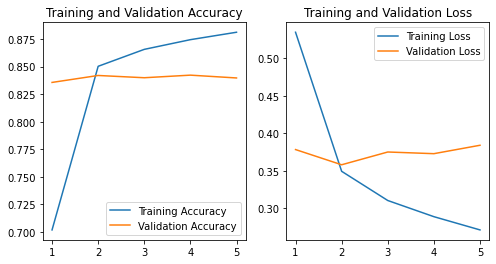

In [14]:
# 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 1-D CNN

In [15]:
vocab_size = 10000
word_vector_dim = 200

# 1-D CNN 모델 설계
cnn = keras.Sequential(name="CNN")
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(8, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

In [16]:
# model 학습
cnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
            
epochs=5

history = cnn.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val),
                  verbose=1)

Epoch 1/5
207/207 [==============================] - 3s 8ms/step - loss: 0.4655 - accuracy: 0.7823 - val_loss: 0.3612 - val_accuracy: 0.8400
Epoch 2/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3225 - accuracy: 0.8626 - val_loss: 0.3515 - val_accuracy: 0.8453
Epoch 3/5
207/207 [==============================] - 1s 6ms/step - loss: 0.2719 - accuracy: 0.8888 - val_loss: 0.3590 - val_accuracy: 0.8447
Epoch 4/5
207/207 [==============================] - 1s 6ms/step - loss: 0.2239 - accuracy: 0.9137 - val_loss: 0.3851 - val_accuracy: 0.8420
Epoch 5/5
207/207 [==============================] - 1s 6ms/step - loss: 0.1756 - accuracy: 0.9361 - val_loss: 0.4227 - val_accuracy: 0.8352


In [17]:
# test set으로 model 평가
cnn_results = cnn.evaluate(X_test,  y_test, verbose=2)
print(cnn_results)

1532/1532 - 3s - loss: 0.4287 - accuracy: 0.8331
[0.4287489950656891, 0.8331054449081421]


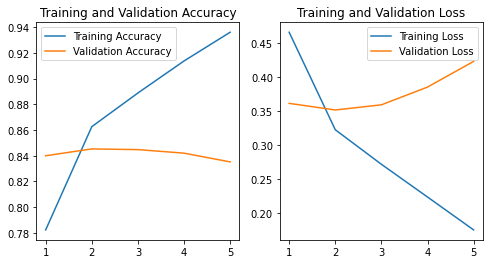

In [18]:
# 시각화
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### GlobalMaxPooling1D

In [19]:
vocab_size = 10000  
word_vector_dim = 200

# GlobalMaxPooling1D 모델 설계
gmp1d = keras.Sequential(name="GlabalMaxPooling1D")
gmp1d.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp1d.add(keras.layers.GlobalMaxPooling1D())
gmp1d.add(keras.layers.Dense(8, activation='relu'))
gmp1d.add(keras.layers.Dense(1, activation='sigmoid'))

gmp1d.summary()

Model: "GlabalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model 학습
gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
            
epochs=5

history = gmp1d.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
207/207 [==============================] - 2s 6ms/step - loss: 0.5078 - accuracy: 0.7857 - val_loss: 0.3654 - val_accuracy: 0.8373
Epoch 2/5
207/207 [==============================] - 1s 5ms/step - loss: 0.3311 - accuracy: 0.8582 - val_loss: 0.3467 - val_accuracy: 0.8470
Epoch 3/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2812 - accuracy: 0.8846 - val_loss: 0.3496 - val_accuracy: 0.8490
Epoch 4/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2408 - accuracy: 0.9046 - val_loss: 0.3650 - val_accuracy: 0.8469
Epoch 5/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2011 - accuracy: 0.9241 - val_loss: 0.3837 - val_accuracy: 0.8449


In [21]:
# test set으로 model 평가
results = gmp1d.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3910 - accuracy: 0.8417
[0.39097294211387634, 0.8417185544967651]


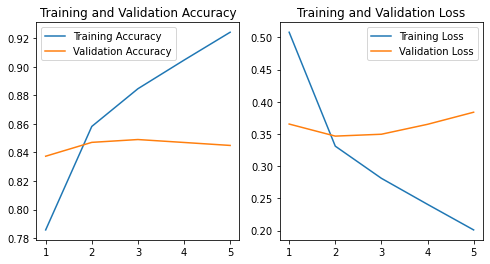

In [22]:
# 시각화
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 모델 비교

In [23]:
print("LSTM 모델의 성능")
LSTM_results = lstm.evaluate(X_test,  y_test, verbose=2)
print("1D-CNN 모델의 성능")
CNN1D_results = cnn.evaluate(X_test,  y_test, verbose=2)
print("GlobalMaxPooling1D 모델의 성능")
GlobalMaxPooling1D_results = gmp1d.evaluate(X_test,  y_test, verbose=2)

LSTM 모델의 성능
1532/1532 - 3s - loss: 0.3851 - accuracy: 0.8385
1D-CNN 모델의 성능
1532/1532 - 3s - loss: 0.4287 - accuracy: 0.8331
GlobalMaxPooling1D 모델의 성능
1532/1532 - 2s - loss: 0.3910 - accuracy: 0.8417


# 학습된 Embedding 레이어 분석

In [24]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


# LSTM
# 임베딩 레이어 차원 확인.
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]
# 학습한 Embedding 파라미터를 파일에 써서 저장.
word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/Ex_6/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록.
vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()



# 1D-CNN
embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/Ex_6/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()



# GlobalMaxPooling1D
embedding_gmp = gmp1d.layers[0]
weights_gmp = embedding_gmp.get_weights()[0]

word2vec_file_path_gmp = os.getenv('HOME')+'/aiffel/Ex_6/word2vec_gmp.txt'
f = open(word2vec_file_path_gmp, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
word_vectors_gmp = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)

In [25]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("행복")

[('낮', 0.8470009565353394),
 ('아쉬울', 0.8443454504013062),
 ('뛰어나', 0.8383393287658691),
 ('기다리', 0.8375727534294128),
 ('요세', 0.8355088233947754),
 ('진솔', 0.8348203897476196),
 ('울', 0.8348076343536377),
 ('나와도', 0.8344777822494507),
 ('노홍철', 0.8332153558731079),
 ('생생', 0.8286263346672058)]

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors.similar_by_word("행복")

[('헨리', 0.590755820274353),
 ('특유', 0.5892919301986694),
 ('금방', 0.5768997669219971),
 ('좋아한다', 0.5634737014770508),
 ('쿵', 0.5634141564369202),
 ('올린다', 0.562516450881958),
 ('평론가', 0.5605564117431641),
 ('데이즈', 0.5603522658348083),
 ('서점', 0.5558199286460876),
 ('손색없', 0.5462963581085205)]

In [27]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)

word_vectors.similar_by_word("행복")

[('고아라', 0.4147314429283142),
 ('살렸', 0.38137397170066833),
 ('오빠', 0.37582337856292725),
 ('평화', 0.3637404441833496),
 ('인물', 0.3614898920059204),
 ('봣는데', 0.36055219173431396),
 ('참신', 0.35954880714416504),
 ('조아', 0.3568788170814514),
 ('연주', 0.3562808930873871),
 ('귀여움', 0.3557380139827728)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

https://github.com/Kyubyong/wordvectors

In [28]:
# !pip install --upgrade gensim==3.8.3

In [29]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/Ex_6/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

#이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = len(index_to_word)    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### LSTM + Kobin

In [30]:
from tensorflow.keras.initializers import Constant

# LSTM_Kobin 설계 
lstm_kobin = keras.Sequential(name="LSTM_Kobin")
lstm_kobin.add(keras.layers.Embedding(vocab_size, 
                                      word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                      input_length=maxlen, 
                                      trainable=True))
lstm_kobin.add(keras.layers.LSTM(128))
lstm_kobin.add(keras.layers.Dense(8, activation='relu'))
lstm_kobin.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_kobin.summary()

Model: "LSTM_Kobin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 오버피팅 없애기
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
     # validataion set의 loss를 monitoring 한다
     # performance measuer(어떤 성능을 모니터링 할것인가?) 를 최소화 시켜야하는 training이다.
     # verbose=1 : 언제 keras에서 training을 멈추었는지 화면에 출력
     # patience : 성능이 더이상 증가하지 않은 epoch를 몇 번이나 허용할 것인가?
    
# EarlyStopping 객체에 의해 training이 중지되었을 때, validation performance가 가장 높았던 모델 선정
mc = ModelCheckpoint('best_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)

In [32]:
# 모델 학습 시작
lstm_kobin.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10

history = lstm_kobin.fit(partial_X_train,
                         partial_y_train,
                         epochs=epochs,
                         batch_size=256,
                         validation_data=(X_val, y_val),
                         verbose=1,
                         callbacks=[es,mc])

Epoch 1/10
414/414 [==============================] - 6s 10ms/step - loss: 0.5472 - accuracy: 0.6857 - val_loss: 0.3862 - val_accuracy: 0.8249
Epoch 2/10
414/414 [==============================] - 4s 9ms/step - loss: 0.3457 - accuracy: 0.8475 - val_loss: 0.3363 - val_accuracy: 0.8529
Epoch 3/10
414/414 [==============================] - 4s 9ms/step - loss: 0.2933 - accuracy: 0.8757 - val_loss: 0.3313 - val_accuracy: 0.8561
Epoch 4/10
414/414 [==============================] - 4s 9ms/step - loss: 0.2574 - accuracy: 0.8929 - val_loss: 0.3397 - val_accuracy: 0.8565
Epoch 5/10
414/414 [==============================] - 4s 9ms/step - loss: 0.2279 - accuracy: 0.9068 - val_loss: 0.3516 - val_accuracy: 0.8533
Epoch 6/10
414/414 [==============================] - 4s 9ms/step - loss: 0.1993 - accuracy: 0.9208 - val_loss: 0.3747 - val_accuracy: 0.8549
Epoch 00006: early stopping


In [33]:
# test set으로 평가하기
lstm_kobin_results = lstm_kobin.evaluate(X_test,  y_test, verbose=2)

print(lstm_kobin_results)

1532/1532 - 3s - loss: 0.3785 - accuracy: 0.8513
[0.37850111722946167, 0.8512705564498901]


### 1D-CNN + Kobin

In [34]:
# 1D-CNN_Kobin 설계 
cnn_kobin = keras.Sequential(name="CNN_Kobin")
cnn_kobin.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=maxlen, 
                                     trainable=True))
cnn_kobin.add(keras.layers.Conv1D(16, 3, activation='relu'))
cnn_kobin.add(keras.layers.MaxPooling1D(5))
cnn_kobin.add(keras.layers.Conv1D(16, 3, activation='relu'))
cnn_kobin.add(keras.layers.GlobalMaxPooling1D())
cnn_kobin.add(keras.layers.Dense(8, activation='relu'))
cnn_kobin.add(keras.layers.Dense(1, activation='sigmoid'))

cnn_kobin.summary()

Model: "CNN_Kobin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 16)            9616      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 16)             784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9 

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_cnn.h5', monitor='val_loss', mode='min', save_best_only=True)

# 모델 학습 시작
cnn_kobin.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10

history = cnn_kobin.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[es,mc])

Epoch 1/10
414/414 [==============================] - 3s 6ms/step - loss: 0.5496 - accuracy: 0.7113 - val_loss: 0.4582 - val_accuracy: 0.7873
Epoch 2/10
414/414 [==============================] - 2s 5ms/step - loss: 0.4049 - accuracy: 0.8170 - val_loss: 0.3940 - val_accuracy: 0.8210
Epoch 3/10
414/414 [==============================] - 2s 6ms/step - loss: 0.3465 - accuracy: 0.8479 - val_loss: 0.3729 - val_accuracy: 0.8318
Epoch 4/10
414/414 [==============================] - 2s 5ms/step - loss: 0.3112 - accuracy: 0.8669 - val_loss: 0.3685 - val_accuracy: 0.8365
Epoch 5/10
414/414 [==============================] - 2s 6ms/step - loss: 0.2850 - accuracy: 0.8821 - val_loss: 0.3718 - val_accuracy: 0.8387
Epoch 6/10
414/414 [==============================] - 2s 5ms/step - loss: 0.2616 - accuracy: 0.8935 - val_loss: 0.3839 - val_accuracy: 0.8396
Epoch 7/10
414/414 [==============================] - 2s 5ms/step - loss: 0.2385 - accuracy: 0.9050 - val_loss: 0.4067 - val_accuracy: 0.8347
Epoch 

### GlobalMaxPooling1D + Kobin

In [36]:
# 1GlobalMaxPooling1D_Kobin 설계 
gmp_kobin = keras.Sequential(name="GlobalMaxPooling1D_Kobin")
gmp_kobin.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=maxlen, 
                                     trainable=True))
gmp_kobin.add(keras.layers.GlobalMaxPooling1D())
gmp_kobin.add(keras.layers.Dense(8, activation='relu'))
gmp_kobin.add(keras.layers.Dense(1, activation='sigmoid'))

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_gmp.h5', monitor='val_loss', mode='min', save_best_only=True)

# 모델 학습 시작
gmp_kobin.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10

history = gmp_kobin.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[es,mc])

Epoch 1/10
414/414 [==============================] - 2s 4ms/step - loss: 0.6393 - accuracy: 0.6147 - val_loss: 0.5609 - val_accuracy: 0.7144
Epoch 2/10
414/414 [==============================] - 2s 4ms/step - loss: 0.5209 - accuracy: 0.7429 - val_loss: 0.5005 - val_accuracy: 0.7570
Epoch 3/10
414/414 [==============================] - 2s 4ms/step - loss: 0.4635 - accuracy: 0.7811 - val_loss: 0.4660 - val_accuracy: 0.7739
Epoch 4/10
414/414 [==============================] - 2s 4ms/step - loss: 0.4249 - accuracy: 0.8049 - val_loss: 0.4400 - val_accuracy: 0.7952
Epoch 5/10
414/414 [==============================] - 2s 4ms/step - loss: 0.3964 - accuracy: 0.8212 - val_loss: 0.4209 - val_accuracy: 0.8039
Epoch 6/10
414/414 [==============================] - 2s 4ms/step - loss: 0.3730 - accuracy: 0.8353 - val_loss: 0.4143 - val_accuracy: 0.8085
Epoch 7/10
414/414 [==============================] - 2s 4ms/step - loss: 0.3526 - accuracy: 0.8473 - val_loss: 0.4062 - val_accuracy: 0.8144
Epoch 

In [38]:
# LSTM_Kobin
print("LSTM_Kobin 모델의 성능")
results_lstm = lstm_kobin.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN_Kobin
print("1D-CNN_Kobin 모델의 성능")
results_cnn = cnn_kobin.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# GlobalMaxPooling1D_Kobin
print("GlobalMaxPooling1D_Kobin 모델의 성능")
results_gmp = gmp_kobin.evaluate(X_test, y_test, verbose=2)
print(results_gmp)

LSTM_Kobin 모델의 성능
1532/1532 - 3s - loss: 0.3785 - accuracy: 0.8513
[0.37850111722946167, 0.8512705564498901]
1D-CNN_kobin 모델의 성능
1532/1532 - 3s - loss: 0.4144 - accuracy: 0.8347
[0.414365291595459, 0.834697425365448]
GlobalMaxPooling1D_Kobin 모델의 성능
1532/1532 - 2s - loss: 0.4191 - accuracy: 0.8122
[0.4190652370452881, 0.8122461438179016]


# 회고

- 결론부터 말하면 정확도 85% 목표는 달성했다.(LSTM + Kobin)
- 사실 기본 모델 적용시에는 생각에 LSTM이 잘 나오지 않아서 뭔가 했지만...(이 부분은 좀 다시 봐야할 듯하다.) 한국어 임베딩 후에 제일 성능이 좋아서 다행이었다.
- 작사가 인공지능 만들기 때부터 이거저거 많이 참고해보면서 하다가 낭패를 봤지만
- 이번에는 노드를 중심으로 조금씩 덧붙여보면서 해봤다.
- 아직은 온전히 내 힘으로 하기는 힘들지만 좀 더 자세한 이론적, 코드적 의미를 살펴가며 정리해서 
- 앞으로의 NLP 노드에 적용해보면 실력이 늘 것 같다.
- 필사라는 것이 캐글 처음 공부할 때 많이 들었는데 조금씩 써보고 이해해보고 하다보면 필사도 나름의 공부법인것 같다.
- LSTM 외에도 2가지 모델을 써서 했는데 외에도 단방향 LSTM으로 했다면 양방향 LSTM도 이전에 해봤었고 나아가서 트랜스포머류의 모델도 적용해서 해봐야겠다.(요즘은 갓 Transformer 시대니깐!)
- 또한 한국어 word2vec을 써서 성능을 올렸는데 한국어 FastText랑도 비교를 해보고 싶어 일단 다운로드는 받아놨고 이것도 따로 적용시켜서 해봐야겠다.
- 마지막으로 힘들어도 Keep Going!!!